<a href="https://colab.research.google.com/github/tsai-praveen/tsai-assignments/blob/main/S6/S6_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample Code here.. Actual code way below

In [ ]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



 bird   dog   dog  ship


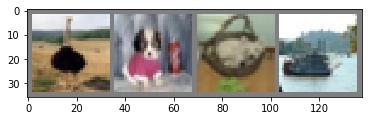

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.185
[1,  4000] loss: 1.848
[1,  6000] loss: 1.678
[1,  8000] loss: 1.573
[1, 10000] loss: 1.524
[1, 12000] loss: 1.480
[2,  2000] loss: 1.399


5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
outputs = net(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

## Actual Code (from class)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [3]:
# Depthwise Convolution class

class DepthwiseSeparable(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super(DepthwiseSeparable, self).__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.stride = stride

        self.depthwise = nn.Sequential(
            nn.Conv2d(in_channels=self.in_ch, out_channels=self.in_ch, kernel_size=(3, 3), padding=1, stride=self.stride, groups=self.in_ch, bias=False),
            nn.Conv2d(in_channels=self.in_ch, out_channels=self.out_ch, kernel_size=(1, 1), bias=False)
        )

    def forward(self, x):
        return self.depthwise(x)

In [4]:
# The network
class Net(nn.Module):
    def __init__(self, drop=0.025):
        super(Net, self).__init__()

        # Define C1 C2 C3 C4 Output blocks
        self.conblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False), # I: 32x32x3 | O: 32x32x32 | RF: 3x3
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Dropout(p=drop),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False), # I: 32x32x32 | O: 32x32x32 | RF: 5x5
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Dropout(p=drop)
        )

        self.transblock1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, stride=2, bias=False), #I: 32x32x32 | O: 16x16x32 | RF: 7x7
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Dropout(p=drop)
        )
        
        self.conblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False), # I: 16x16x32 | O: 16x16x64 | RF: 11x11
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Dropout(p=drop)
        )

        self.transblock2 = nn.Sequential(
            DepthwiseSeparable(in_ch=64, out_ch=64, stride=2), #I: 16x16x64 | O: 8x8x64 | RF: 15x15
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Dropout(p=drop)
        )

        self.conblock3 = nn.Sequential(
            DepthwiseSeparable(in_ch=64, out_ch=128), #I: 8x8x64 | O: 8x8x128 | RF: 23x23
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Dropout(p=drop),

            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), bias=False), # I: 8x8x128 | O: 8x8x32 | RF: 23x23
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Dropout(p=drop)
        )

        self.transblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, dilation=2, bias=False), # I: 8x8x32 | O: 6x6x32 | RF: 39x39
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, dilation=2, bias=False), # I: 6x6x32 | O: 4x4x32 | RF: 55x55
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Dropout(p=drop)
        )

        self.conblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False), # I: 4x4x32 | O: 4x4x32 | RF: 63x63
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(3, 3), padding=1, bias=False), # I: 4x4x32 | O: 4x4x10 | RF: 71x71
            
        )

        self.gap = nn.AvgPool2d(kernel_size=4)

    def forward(self, x):
        x = self.transblock1(self.conblock1(x))
        x = self.transblock2(self.conblock2(x))
        x = self.transblock3(self.conblock3(x))
        x = self.conblock4(x)
        x = self.gap(x)
        x = x.view(-1, 10)

        return F.log_softmax(input=x, dim=-1)


In [5]:
import matplotlib.pyplot as plt
import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm
 

In [6]:
exp = datasets.CIFAR10('./data', train=True, download=True)
exp_data = exp.data

# Calculate the mean and standard deviation for normalization
print('[Train]')
print(' - Numpy Shape : ', exp_data.shape)
print(' - min:', np.min(exp_data, axis=(0,1,2))/255.)
print(' - max:', np.max(exp_data, axis=(0,1,2))/255.)
print(' - mean:', np.mean(exp_data, axis=(0,1,2))/255.)
print(' - std:', np.std(exp_data, axis=(0,1,2))/255.)
print(' - var:', np.var(exp_data, axis=(0,1,2))/255.)

Files already downloaded and verified
[Train]
 - Numpy Shape :  (50000, 32, 32, 3)
 - min: [0. 0. 0.]
 - max: [1. 1. 1.]
 - mean: [0.49139968 0.48215841 0.44653091]
 - std: [0.24703223 0.24348513 0.26158784]
 - var: [15.56135559 15.11767693 17.44919073]


In [7]:
exp.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [8]:
def viz_data(cols=8, rows=5):
    figure = plt.figure(figsize=(14, 10))
    for i in range(1, cols*rows+1):
        img, label = exp[i]

        figure.add_subplot(rows, cols, i)
        plt.title(exp.classes[label])
        plt.axis('off')
        plt.imshow(img, cmap='gray')

    plt.tight_layout()
    plt.show()


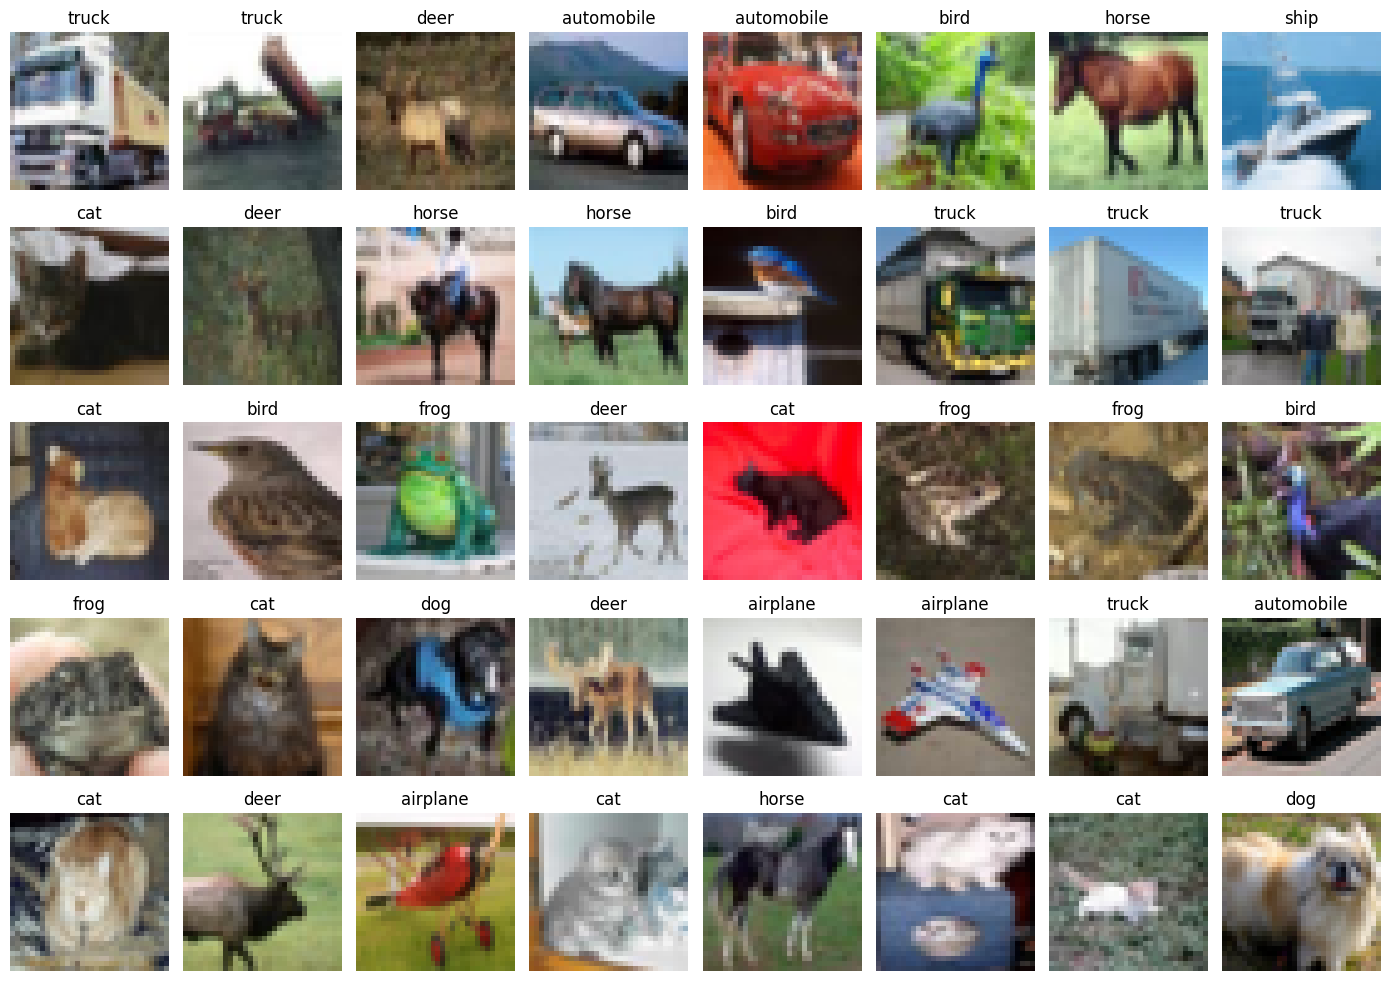

In [9]:
viz_data()

In [10]:
def show_images(aug_dict, ncol=6):
    nrow = len(aug_dict)

    fig, axes = plt.subplots(ncol, nrow, figsize=(3*nrow, 15), squeeze=False)

    for i, (key, aug) in enumerate(aug_dict.items()):
        for j in range(ncol):
            ax = axes[j, i]
            if j==0:
                ax.text(0.5, 0.5, key, horizontalalignment='center', verticalalignment='center', fontsize=15)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                ax.axis('off')
            else:
                image, label = exp[j-1]
                if aug is not None:
                    transform = A.Compose([aug])
                    image = np.array(image)
                    image = transform(image=image)['image']

                ax.imshow(image)
                ax.set_title(f'{exp.classes[label]}')
                ax.axis('off')

    plt.tight_layout()
    plt.show()

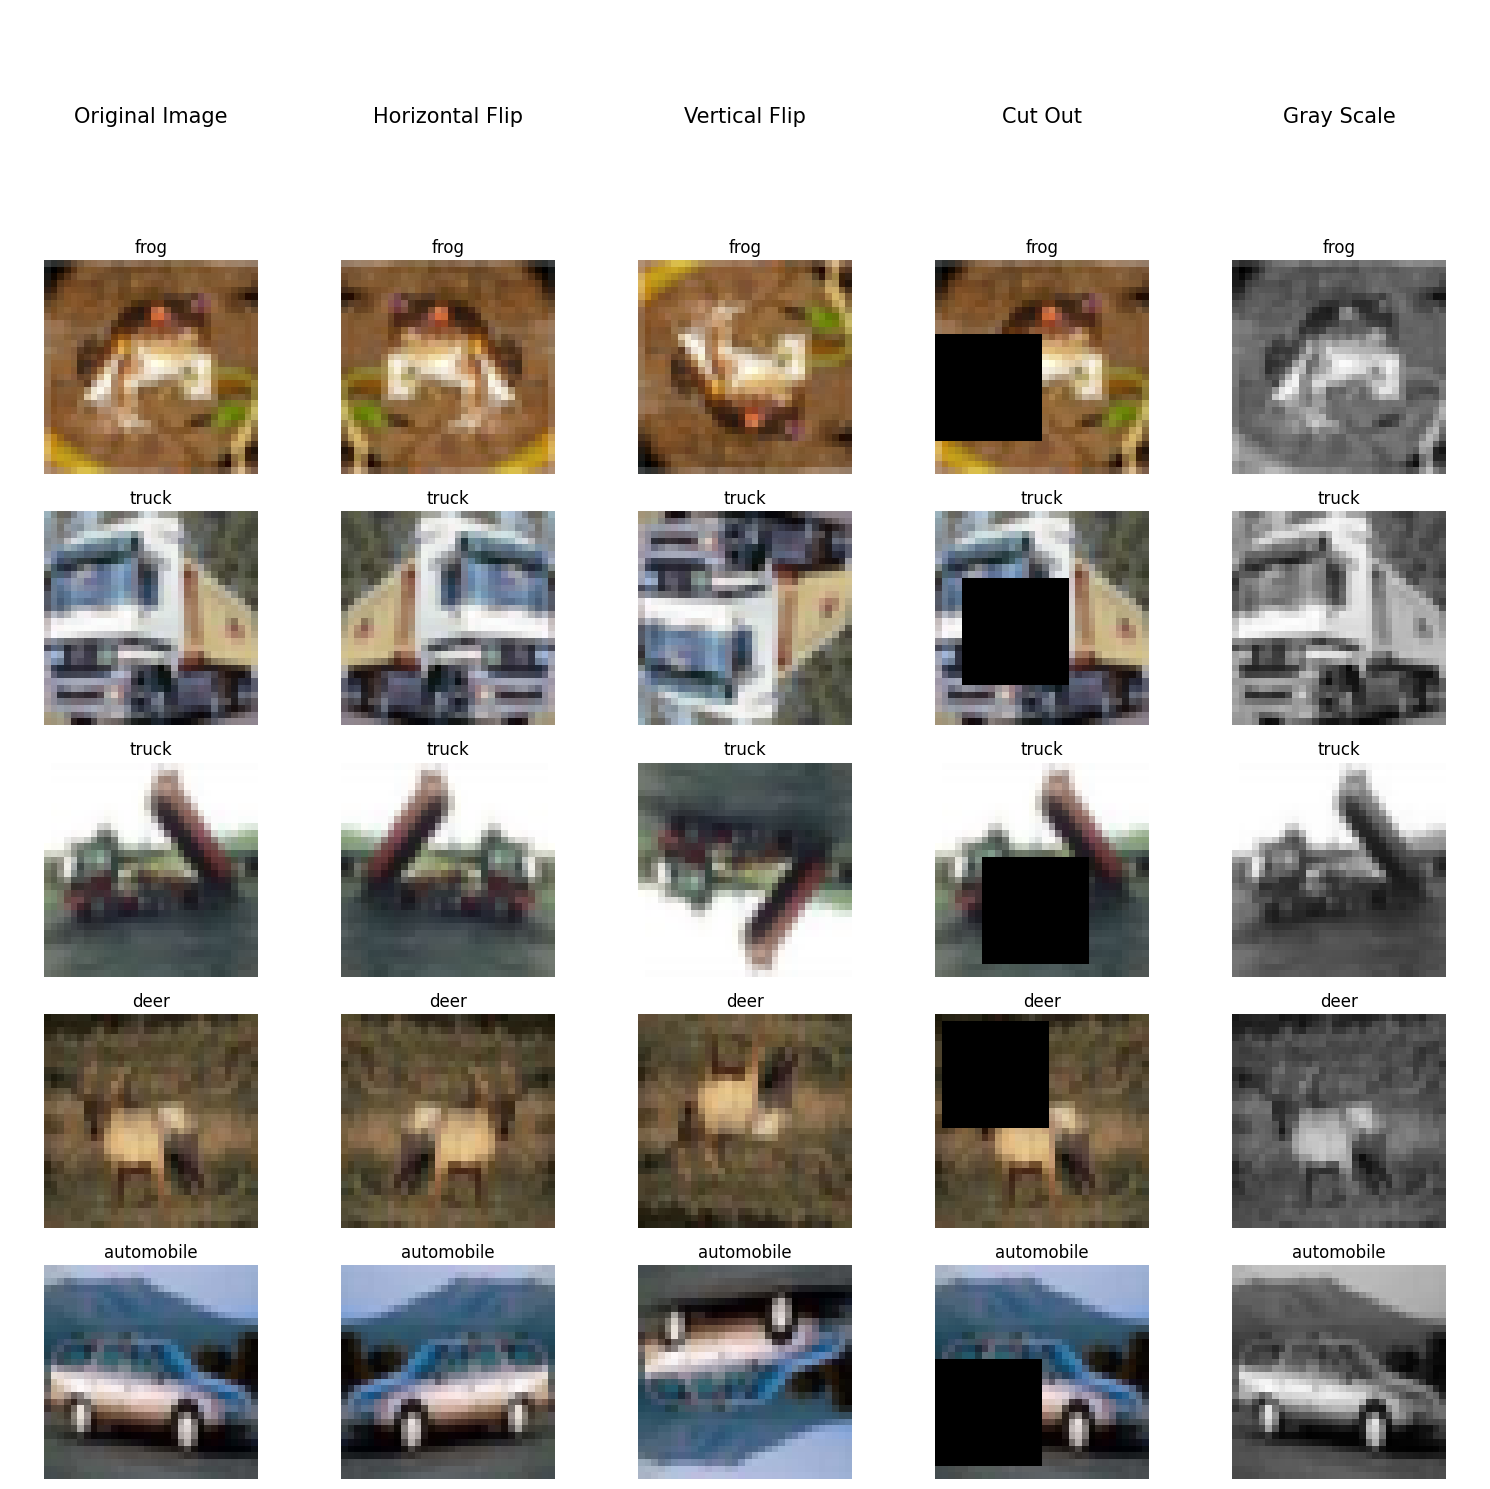

In [11]:
show_images({
    'Original Image' : None, 
    'Horizontal Flip': A.HorizontalFlip(always_apply=True),
    'Vertical Flip': A.VerticalFlip(always_apply=True),
    'Cut Out': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16,
                               min_width=16, fill_value=0.473363, mask_fill_value=None, always_apply=True),
    'Gray Scale': A.ToGray(always_apply=True)    
})

In [16]:
class AlbumentationImageDataset(Dataset):
    def __init__(self, image_list, train=True) -> None:
        self.image_list = image_list
        self.aug = A.Compose({
            A.Normalize(mean=(0.49139968, 0.48215841, 0.44653091), std=(0.24703223, 0.24348513, 0.26158784)),
            A.HorizontalFlip(),
            A.ShiftScaleRotate(),
            A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16,
                               min_width=16, fill_value=0.473363, mask_fill_value=None),
            A.ToGray()
        })

        self.norm = A.Compose({
            A.Normalize(mean=(0.49139968, 0.48215841, 0.44653091), std=(0.24703223, 0.24348513, 0.26158784))
        })

        self.train = train

    def __len__(self):
        return(len(self.image_list))
    
    def __getitem__(self, i):
        image, label = self.image_list[i]
        print("Label : ", label)

        if self.train:
            image = self.aug(image=np.array(image))['image']
        else:
            image = self.norm(image = np.array(image))['image']

        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        return torch.tensor(image, dtype=torch.float), label

In [17]:
SEED = 1

# CUDA available?
cuda = torch.cuda.is_available()
print(f"CUDA Available : {cuda}")

# For reproducability
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
BATCH_SIZE = 64




CUDA Available : True


In [18]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

train_loader = DataLoader(AlbumentationImageDataset(image_list=trainset, train=True), batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(AlbumentationImageDataset(image_list=testset, train=False), batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
some_alb = AlbumentationImageDataset(image_list=trainset, train=True)
some_alb[0]

Label :  6


(tensor([[[ 0.0586,  0.0745,  0.1856,  ..., -1.2272, -1.2749, -1.0209],
          [-0.4970, -0.5605, -0.4811,  ..., -1.8305, -1.9892, -1.6876],
          [-0.7192, -0.5446, -0.5605,  ..., -1.4971, -1.8463, -1.6082],
          ...,
          [-1.3860, -1.4177,  0.1380,  ...,  0.5031,  0.4555,  0.7571],
          [-1.0367, -0.8939,  0.4396,  ...,  0.2967,  0.0586,  0.3285],
          [-0.4176, -0.0207,  1.0111,  ...,  0.3444,  0.1856,  0.4079]],
 
         [[ 0.0974,  0.1135,  0.2263,  ..., -1.2072, -1.2555, -0.9978],
          [-0.4663, -0.5307, -0.4502,  ..., -1.8192, -1.9802, -1.6742],
          [-0.6918, -0.5146, -0.5307,  ..., -1.4810, -1.8353, -1.5937],
          ...,
          [-1.3682, -1.4004,  0.1780,  ...,  0.5484,  0.5001,  0.8061],
          [-1.0139, -0.8689,  0.4840,  ...,  0.3390,  0.0974,  0.3712],
          [-0.3857,  0.0169,  1.0638,  ...,  0.3873,  0.2263,  0.4518]],
 
         [[ 0.2269,  0.2419,  0.3468,  ..., -0.9874, -1.0324, -0.7925],
          [-0.2978, -0.3578,

In [14]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print(device)

net = Net(drop=0.0).to(device)
summary(model=net, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]           9,216
      BatchNorm2d-10           [-1, 32, 16, 16]              64
             ReLU-11           [-1, 32, 16, 16]               0
          Dropout-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432
      BatchNorm2d-14           [-1

In [15]:
def train(model, device, train_loader, optimizer, l1, scheduler):
    model.train()

    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    num_loops = 0
    train_loss = 0

    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()

        # In pytorch, we need to set the gradient to zero before starting to do backpropagation
        # Because pytorch will accumulate the gradients on subsequent passes. 
        # Hence, when you start training loop, zero out your gradients so that parameter update is done correctly

        # Predict 
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        l1 = 0
        lambda_l1 = 0.01

        if l1:
            for p in model.parameter():
                l1 = l1 + p.abs().sum()

        loss = loss + lambda_l1*l1
        optimizer.step()

        train_loss += loss.item()

        # Update LR
        scheduler.step()

        # Update pbar-tqdm
        pred = y_pred.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        num_loops += 1
        pbar.set_description(desc=f"Batch_id={batch_idx} Loss={train_loss/num_loops:.5f} Accuracy={100 * correct / processed:0.2f}")

    return 100*correct/processed, train_loss/num_loops


In [16]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdims=True) # get the index of the max log probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print("\n Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n".format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return 100. * correct / len(test_loader.dataset), test_loss
                            


In [17]:
def fit_model(net, NUM_EPOCHS=20, l1=False, l2=False):
    training_acc, training_loss, testing_acc, testing_loss = list(), list(), list(), list()

    if l2:
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
    else:
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=0.017, epochs=NUM_EPOCHS, steps_per_epoch=len(train_loader))

    for epoch in range(1, NUM_EPOCHS+1):
        print(f"EPOCH : {epoch}")
        train_acc, train_loss = train(net, device, train_loader, optimizer, l1, scheduler)
        test_acc, test_loss = test(net, device, test_loader)

        training_acc.appen(train_acc)
        training_loss.append(train_loss)
        testing_acc.append(test_acc)
        testing_loss.append(test_loss)

    return net, (training_acc, training_loss, testing_acc, testing_loss)

In [18]:
net, history = fit_model(net, NUM_EPOCHS=100)

EPOCH : 1


  0%|          | 0/782 [00:00<?, ?it/s]